![House](![House](file:///E:/phase%204%20project/phase-4-group-project/images/house.jpg))




# TIME SERIES FOR PREDICTING HOUSE PRICES 
### Authors 
* Emily Njue 
* Nelson Kibet Kemboi 
* Brian Muli 
* Joel Omondi 
* Ian Tulienge 
* Lavender Echesa 


In [236]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")
 

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf


In [216]:
#loading the dataset 
data = pd.read_csv('zillow_data.csv')
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [217]:
#checking columns
data.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '1996-04', '1996-05', '1996-06',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=272)

In [218]:
# A function to print the shape of our datasets
def print_dataset_shape(*datasets):
    """
    Prints the shape of one or more datasets (number of rows and columns).
    Assumes datasets are in a Pandas DataFrame format.
    """
    for idx, dataset in enumerate(datasets):
        print(f"Dataset {idx + 1} - Number of rows: {dataset.shape[0]}")
        print(f"Dataset {idx + 1} - Number of columns: {dataset.shape[1]}")
# print the shape of our dataset
print_dataset_shape(data)

Dataset 1 - Number of rows: 14723
Dataset 1 - Number of columns: 272


In [219]:
#getting the info of dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


# Data Preprocessing

In [220]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

out of top 50 sizerank:
* find top 5 ROI value today / value original * zip codes
* forecast 3 year investment horizon for each zipcode
* refine model
* choose best zipcode to invest

In [221]:
#select top 50 sized zipcodes according to sizerank
top_50_size = data.iloc[:50]
top_50_size

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,776500.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500


In [222]:
#calculate ROI for each zip code
top_50_size['ROI'] = (top_50_size['2018-04'] / top_50_size['1996-04']) - 1
top_50_size.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,2.083782
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,310000,312500,314100,315000,316600,318100,319600,321100,321800,0.365295
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320600,320200,320400,320800,321200,321200,323000,326900,329900,0.567966
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,1.623971
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119400,120000,120300,120300,120300,120300,120500,121000,121500,0.571798


In [223]:
#select 10 largest ROI
top_50_size['ROI'].nlargest(n=10)

29    6.330859
33    5.030201
10    4.945679
30    4.774809
47    4.195133
9     3.978460
46    3.323709
12    3.297147
13    3.284514
15    3.040656
Name: ROI, dtype: float64

In [224]:
top5 = top_50_size.iloc[[29, 33, 10, 30, 47]]
top5

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI
29,66126,20002,Washington,DC,Washington,District of Columbia,30,94300.0,94000.0,93700.0,...,668000,672200,673100,674600,678200,680900,683000,687500,691300,6.330859
33,66133,20009,Washington,DC,Washington,District of Columbia,34,178800.0,179200.0,179600.0,...,1027500,1034300,1040500,1047400,1055400,1065900,1076400,1081000,1078200,5.030201
10,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,851000,853900,870000,885100,887800,890500,901700,930700,963200,4.945679
30,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,340600.0,341700.0,343000.0,...,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900,4.774809
47,62040,11230,New York,NY,New York,Kings,48,230100.0,230800.0,231500.0,...,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400,4.195133


* Once we have calculated the return on investment (ROI) for various zip codes over a historical period, we can identify the top five zip codes with the highest returns. We will now focus our analysis on these five zip codes and make projections for the next three years into the future.

# DATA PREPROCESSING
* We changed our data from wide range to long format for easier analysis 

In [225]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName', 'ROI'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [226]:
#melt data to reformat
melted_data = melt_data(top5)
melted_data.head()

,value
time,
1996-04-01,201160.0
1996-05-01,201600.0
1996-06-01,202080.0
1996-07-01,202620.0
1996-08-01,203200.0


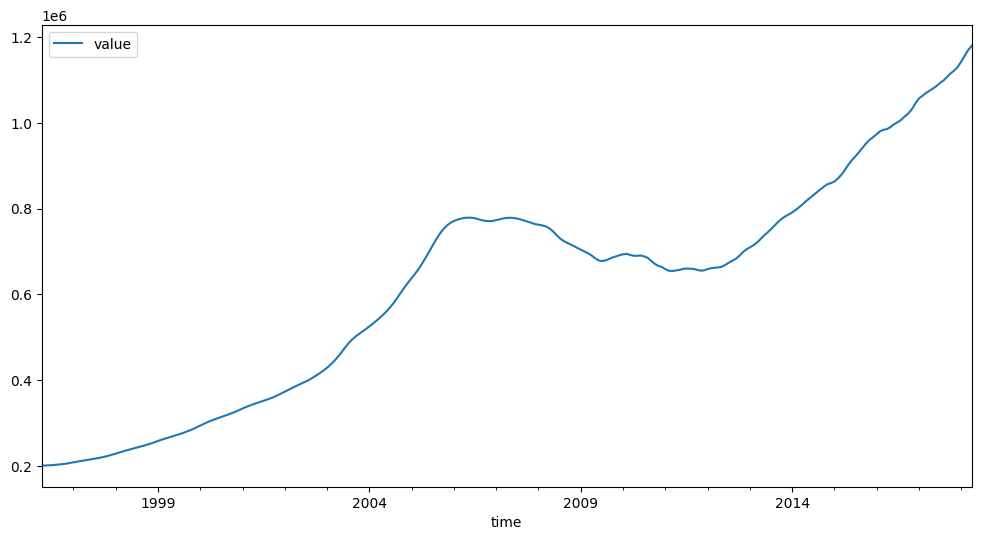

In [227]:
#ploting our melted data 
melted_data.plot(figsize=(12,6));

* The data reveals a consistent upward trend in housing prices for the selected zip codes. However, there are also cyclical fluctuations that align with the broader business cycle, including periods of recession such as the `post-2008 lows` and subsequent periods of growth.

* In recent years, there has been a notable surge in housing prices, which can be attributed to two main factors: unprecedented supply shortages and historically low interest rates. These factors have created a significant demand-supply imbalance, driving up prices and leading to a breakout in the housing market.

In [228]:
#separate each region
Washington_20002 = top5.iloc[[0]]
Washington_20009 = top5.iloc[[1]]
NewYork_11226 = top5.iloc[[2]]
LosAngeles_90046 = top5.iloc[[3]]
NewYork_11230= top5.iloc[[4]]


In [229]:
#melting top five regions 
melted_r1 = melt_data(Washington_20002)
melted_r2 = melt_data(Washington_20009)
melted_r3 = melt_data(NewYork_11226)
melted_r4 = melt_data(NewYork_11230)
melted_r5 = melt_data(LosAngeles_90046)


In [230]:
#defining a function to visualize tiem series for top 5 regions 
def melt_and_visualize_regions(regions):
    region_names = ["Washington_20002", "Washington_20009", "NewYork_11226", "LosAngeles_90046", "NewYork_11230"]
    num_regions = len(regions)
    fig, ax = plt.subplots(figsize=(15, 8))
    
    for i, region in enumerate(regions):
        melted_data = melt_data(region)
        ax.plot(melted_data)
    
    ax.legend(region_names[:num_regions])
    
    title_mapping = {
        1: "Washington_20002",
        2: "Washington_20009",
        3: "NewYork_11226",
        4: "LosAngeles_90046",
        5: "NewYork_11230"
    }
    title = title_mapping.get(num_regions, "Time Series Data for Multiple Regions")
    ax.set_title(title)
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    
    plt.show()

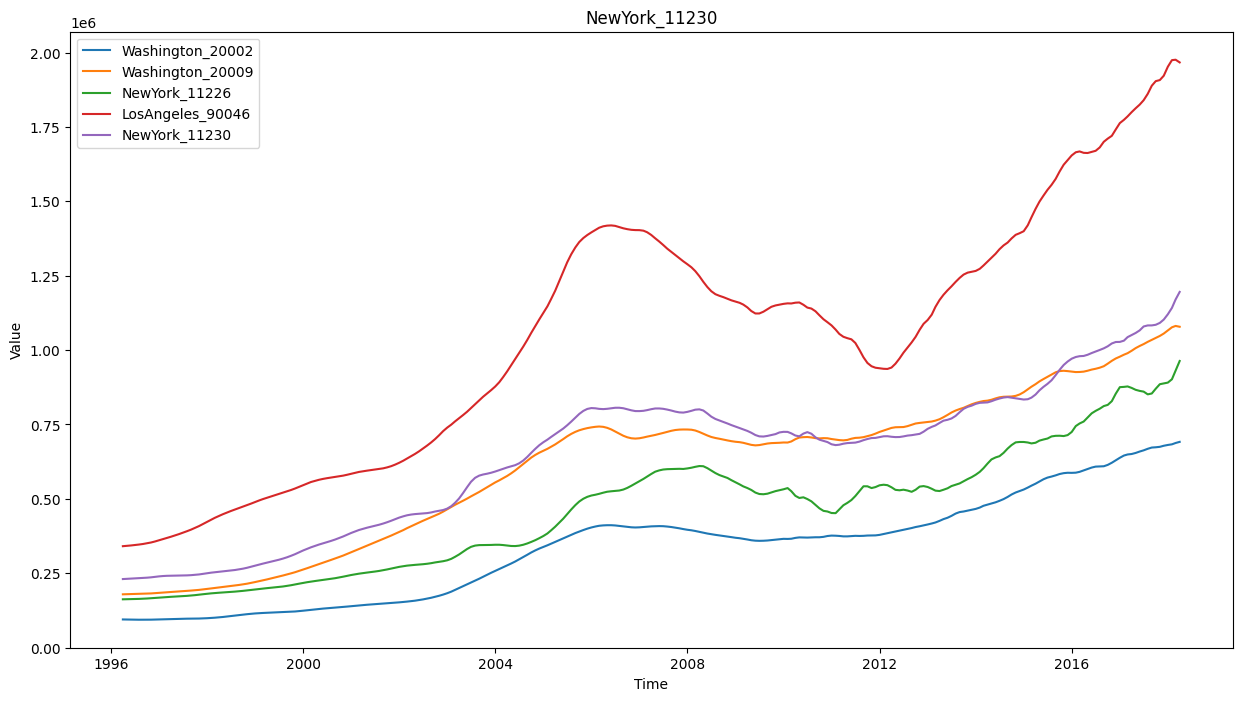

In [231]:
#calling the function to plot the graph
regions = [Washington_20002, Washington_20009, NewYork_11226, LosAngeles_90046, NewYork_11230]
melt_and_visualize_regions(regions)


* In each of the regions `"Washington_20002", "Washington_20009", "NewYork_11226", "LosAngeles_90046", "NewYork_11230"`, we can observe the boom and bust cycle that was previously discussed. The boom and bust cycle refers to the pattern of economic growth followed by a period of decline or recession.

* Some regions fared better than others in weathering the post-2008 lows. This can be seen by comparing the depth of the trough, which represents the lowest point in the economic cycle. Regions that experienced a lower trough were more resilient and recovered faster from the economic downturn.

* However, despite the variations in the severity of the bust cycle, all regions have shown an overall upward trend in recent years. This indicates that the economy in each region has been recovering and growing steadily. The upward trend suggests positive economic conditions and reflects the resilience and strength of these regions in bouncing back from the previous recession.

# EDA AND VISUALIZATION

In [232]:
melted_data

,value
time,
1996-04-01,201160.0
1996-05-01,201600.0
1996-06-01,202080.0
1996-07-01,202620.0
1996-08-01,203200.0
...,...
2017-12-01,1129180.0
2018-01-01,1141980.0
2018-02-01,1155440.0


### Time Series

* In order to prepare the data for the modeling process, we decided to drop the columns that would not be necessary for the modeling process and remain with the pricipal feature(time) together with the target feature(value).

* We are also going to format the time index column to represent a different frequency, that is, months. This is done to try and reduce the number or row entries in the datset.

* Time series data is observed at different points in time and can be used to forecast future values based on past observations. ARIMA (AutoRegressive Integrated Moving Average) is a commonly used model for time series forecasting. It incorporates parameters like p (auto-regressive), d (integrated), and q (moving average) to capture seasonality, trend, and noise in the data. If the time series has a seasonal component, a seasonal ARIMA model (SARIMA) is used with additional parameters P, D, and Q.

## STATIONERITY 

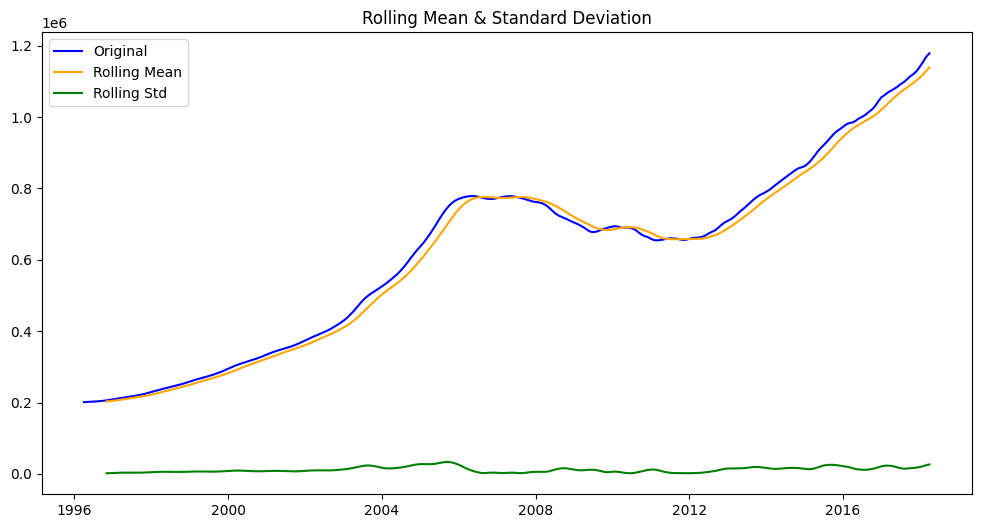

Results of Dickey-Fuller Test: 

Test Statistic                  -0.430282
p-value                          0.904919
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64

The time series is likely non-stationary.


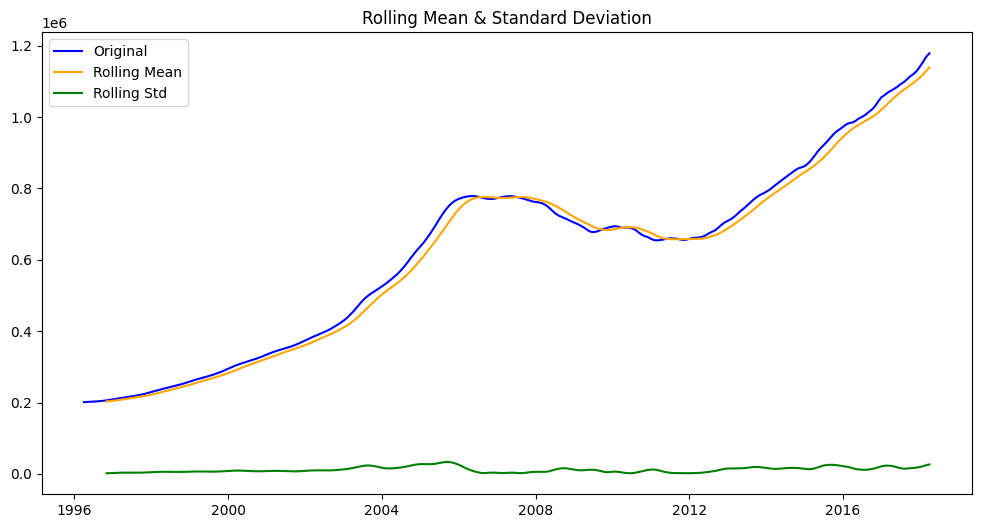

Results of Dickey-Fuller Test: 

Test Statistic                  -0.430282
p-value                          0.904919
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64

The time series is likely non-stationary.


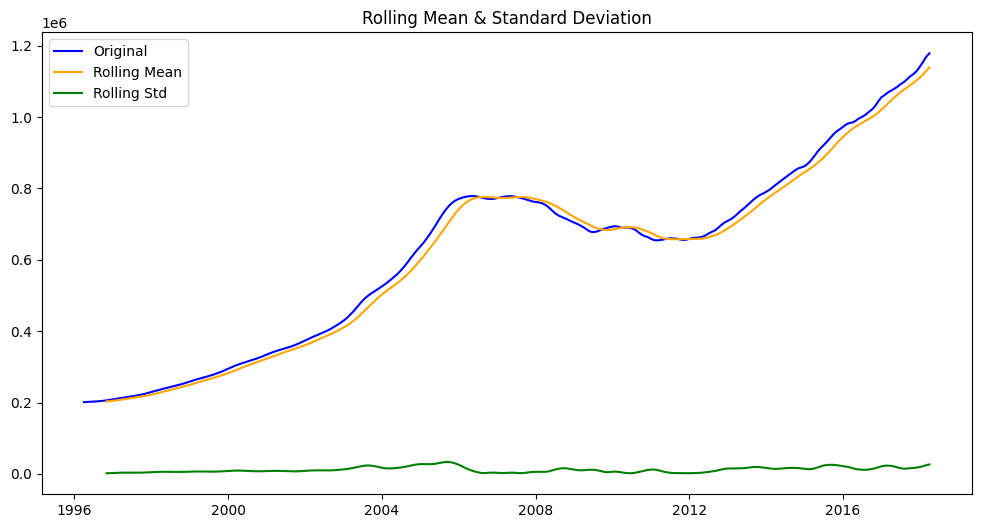

Results of Dickey-Fuller Test: 

Test Statistic                  -0.430282
p-value                          0.904919
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64

The time series is likely non-stationary.


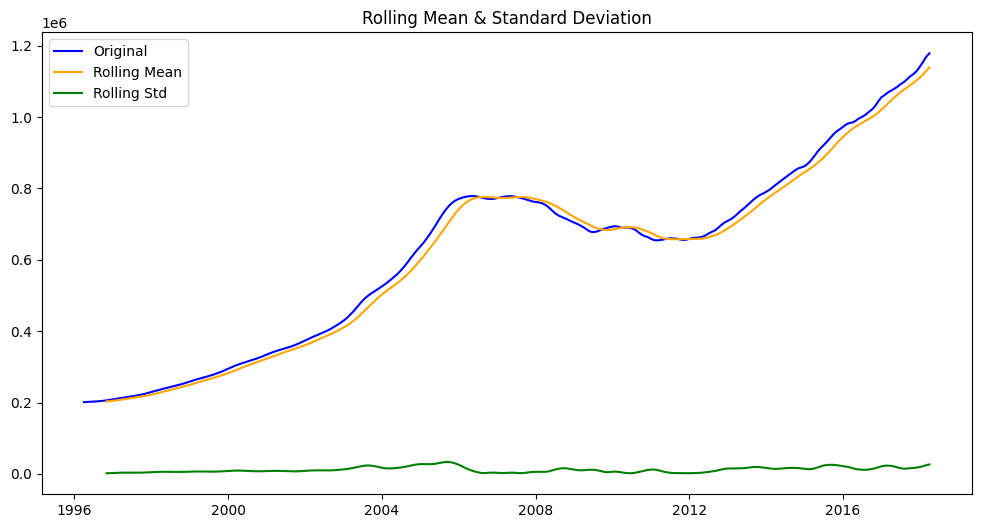

Results of Dickey-Fuller Test: 

Test Statistic                  -0.430282
p-value                          0.904919
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64

The time series is likely non-stationary.


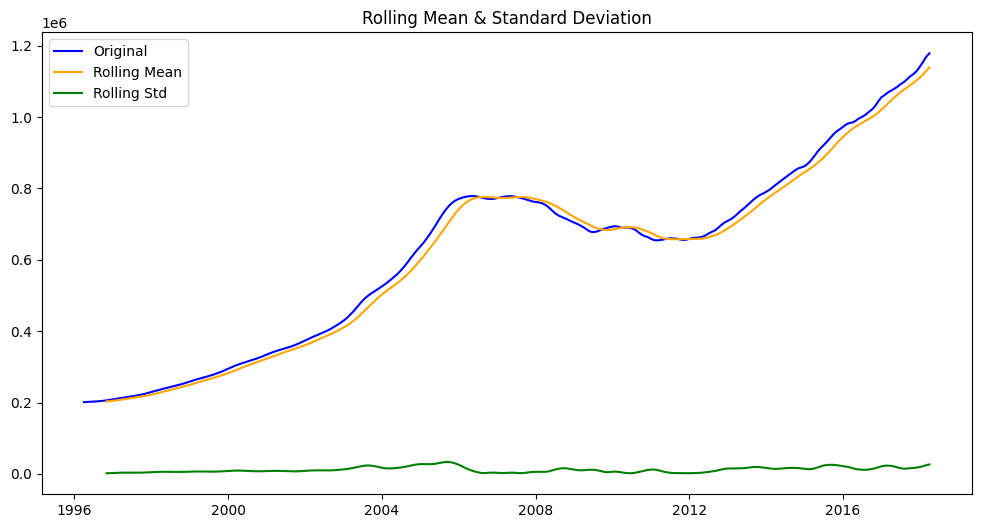

Results of Dickey-Fuller Test: 

Test Statistic                  -0.430282
p-value                          0.904919
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64

The time series is likely non-stationary.


In [233]:
def stationarity_check(TS):
    # Calculate rolling statistics
    roll_mean = melted_data.rolling(window=8, center=False).mean()
    roll_std = melted_data.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(melted_data) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(melted_data, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='orange', label='Rolling Mean')
    std = plt.plot(roll_std, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    # Extract the test statistic and p-value from the result
    test_statistic = dftest[0]
    p_value = dftest[1]
    
    # Check if the time series is stationary based on the p-value
    if p_value <= 0.05:
        print("\nThe time series is likely stationary.")
    else:
        print("\nThe time series is likely non-stationary.")
    
    return None

# Check stationarity for Washington_20002
stationarity_check(Washington_20002)

# Check stationarity for Washington_20009
stationarity_check(Washington_20009)

# Check stationarity for LosAngeles_90046
stationarity_check(LosAngeles_90046)

# Check stationarity for NewYork_11226
stationarity_check(NewYork_11226)

# Check stationarity for ewYork_11230
stationarity_check(NewYork_11230)

* The Dickey-Fuller test results indicate that none of the time series pass the test, suggesting that they are all non-stationary. In order to apply forecasting models, such as ARIMA, it will be necessary to apply differencing and/or incorporate moving average terms to make the series stationary.

* To gain further insights into the individual time series and their underlying components, we can utilize the seasonal_decompose function. This function helps visualize the decomposition of the time series into its trend, seasonality, and residual components. By examining these components, we can better understand the patterns and fluctuations within the data.

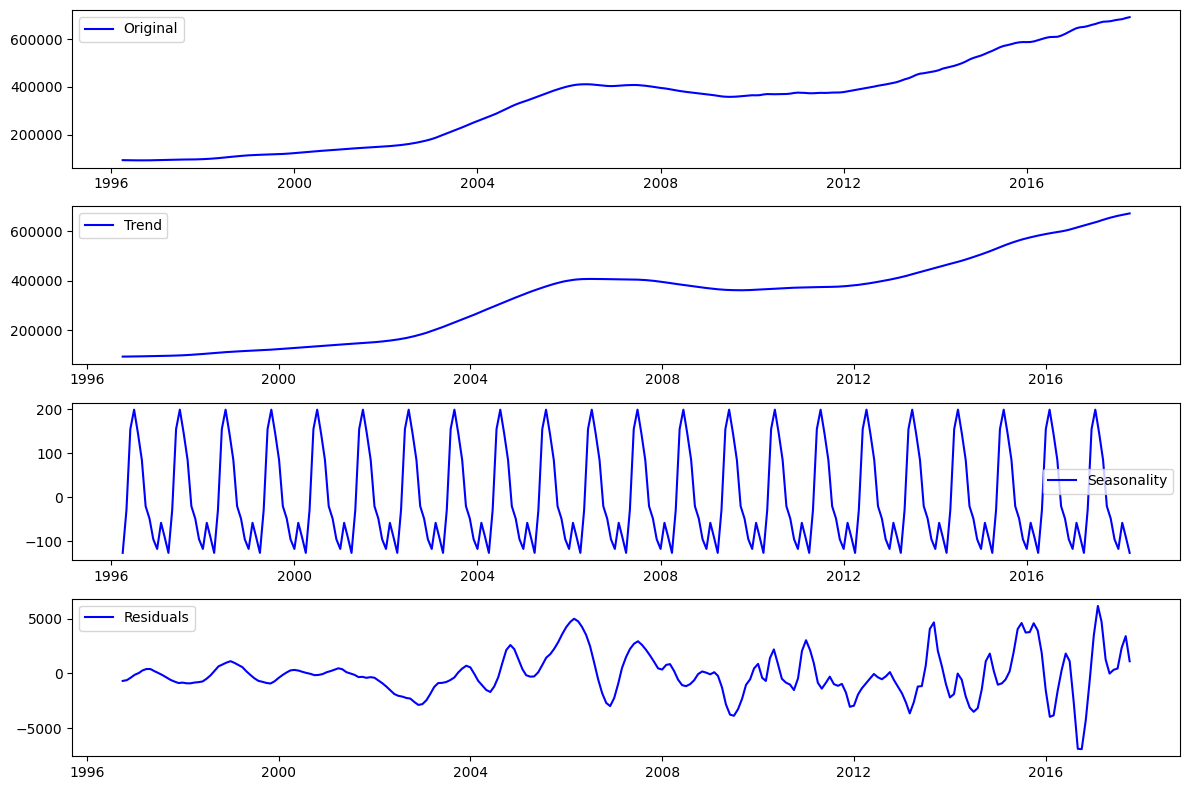

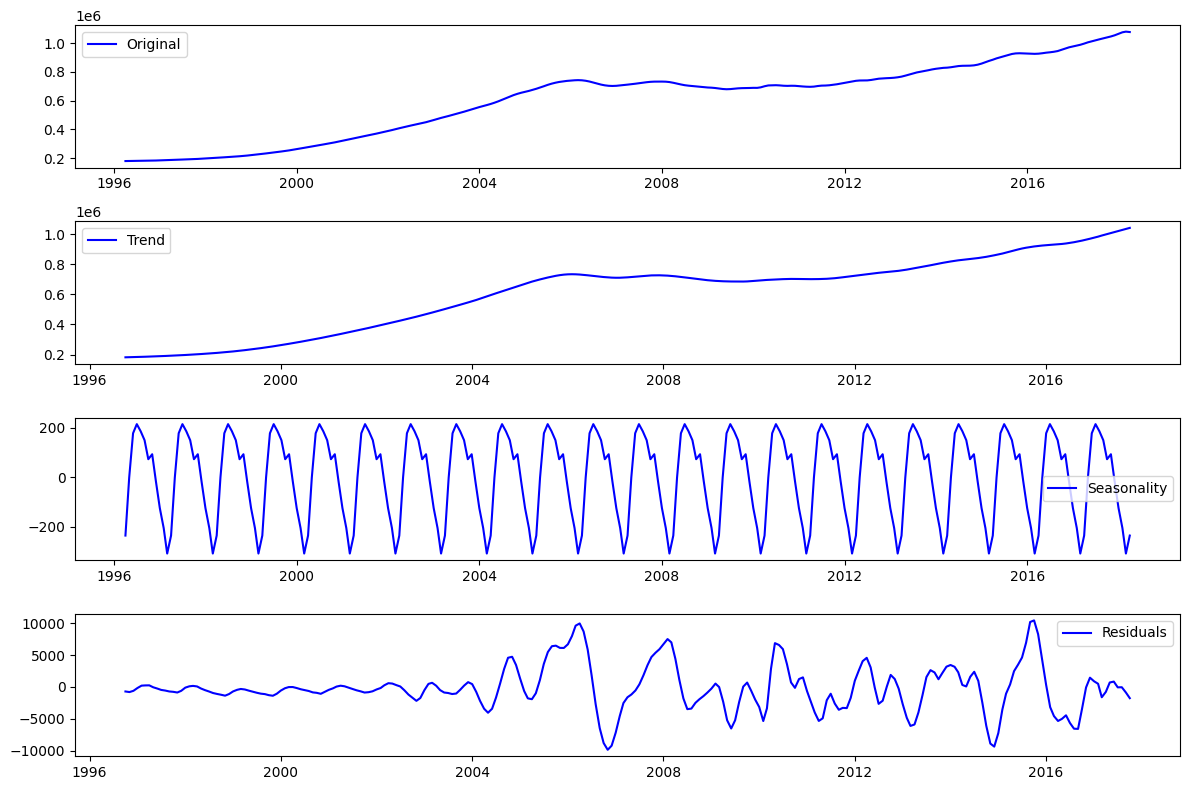

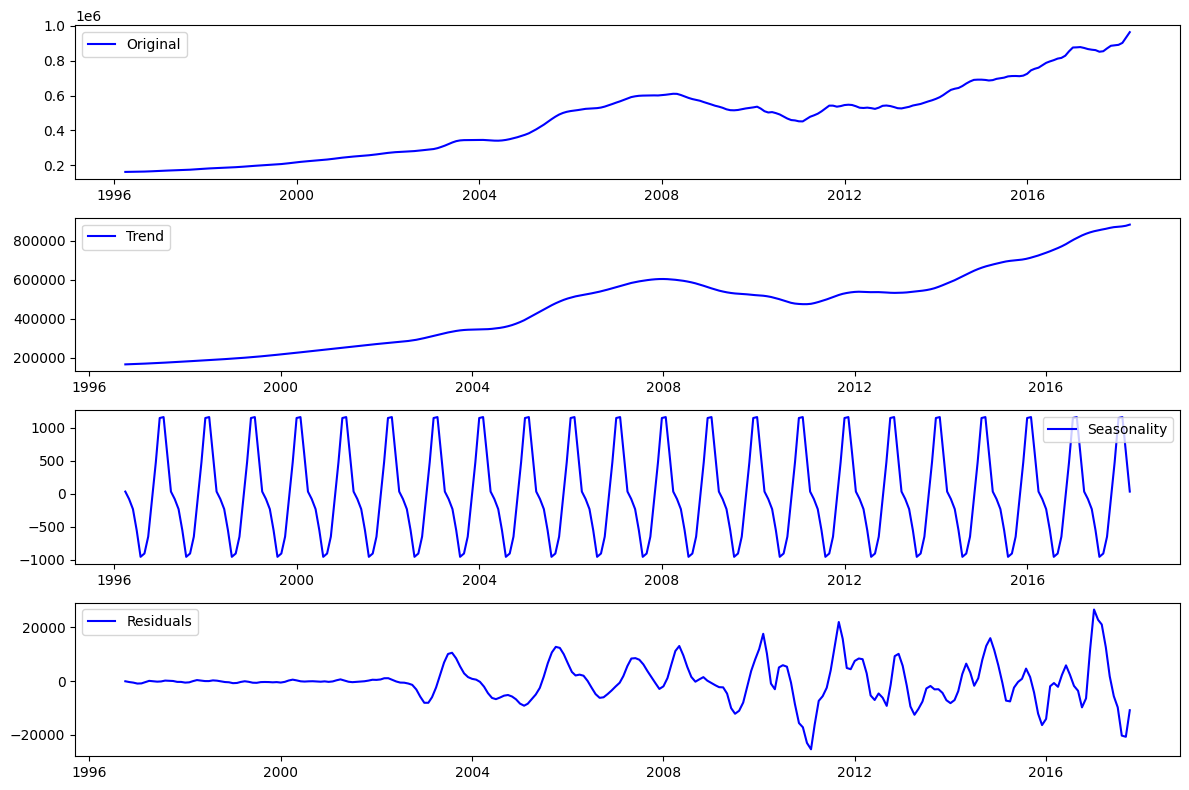

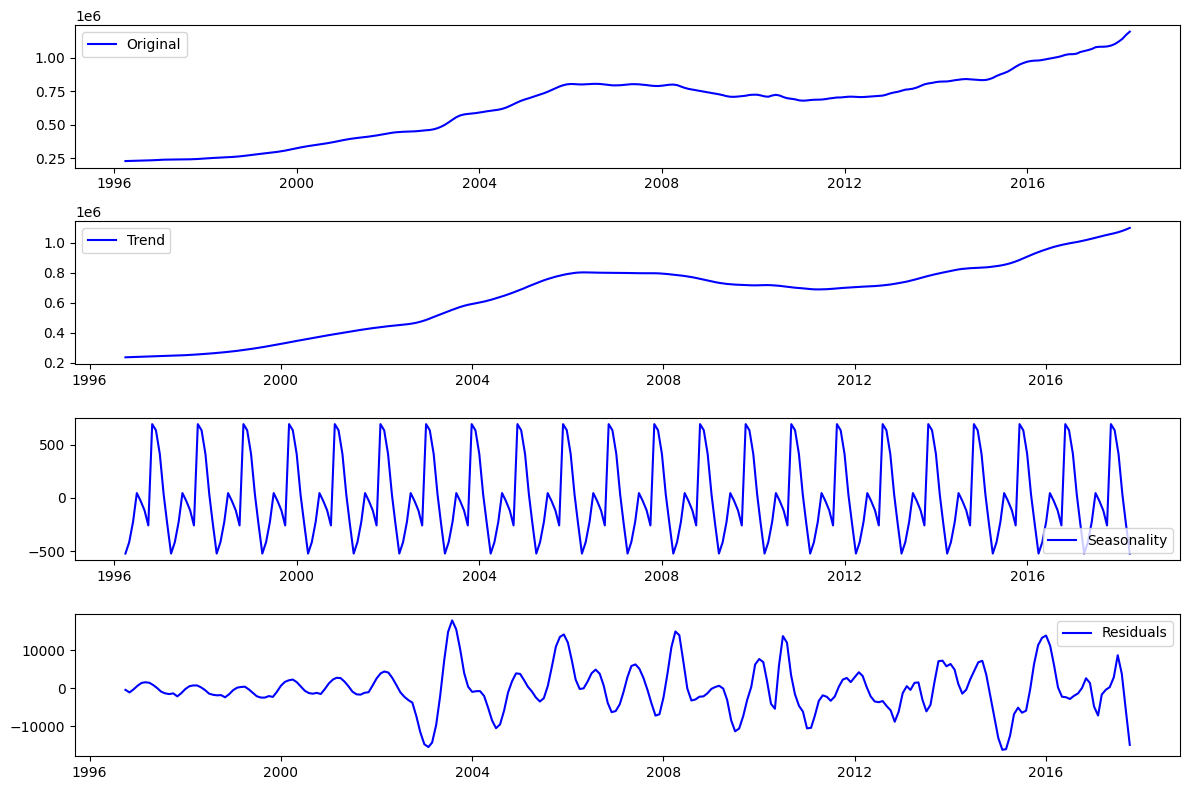

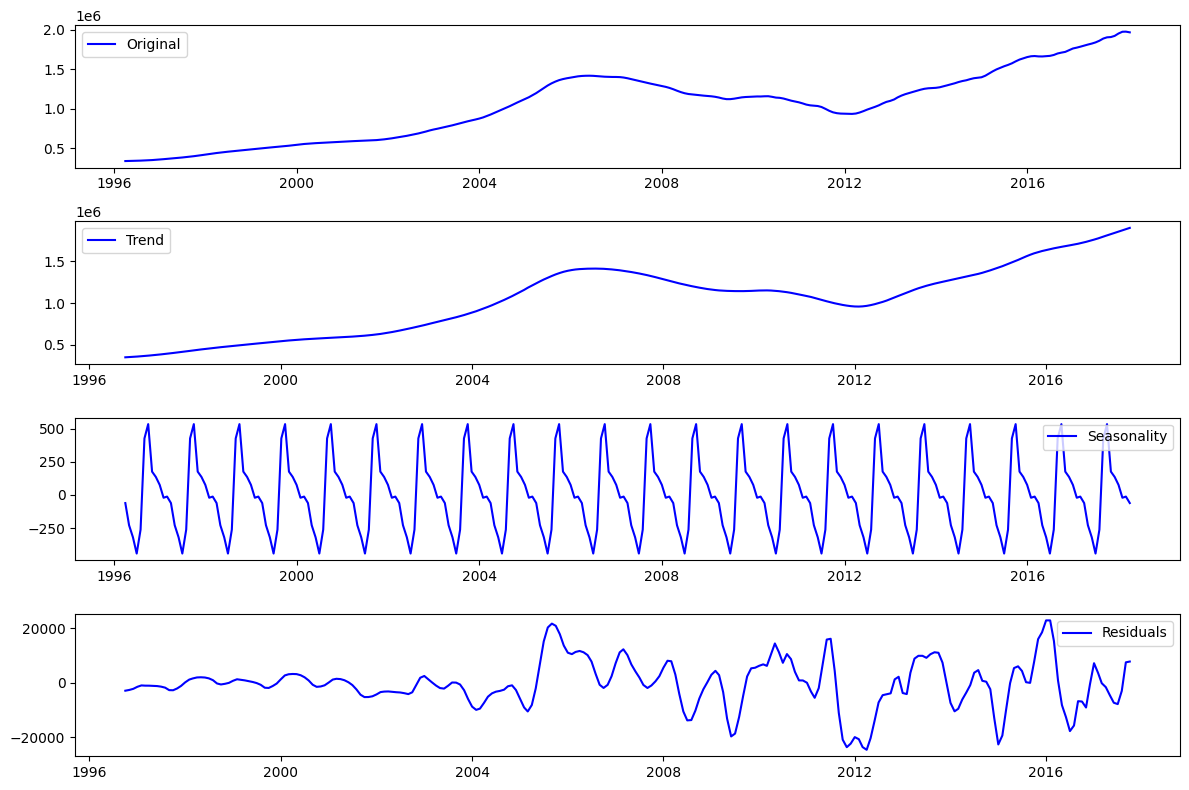

In [234]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Define a function for decomposition and plotting
def decompose_and_plot(time_series):
    decomposition = seasonal_decompose(time_series)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(time_series, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

# Time series r1
decomposition_r1 = seasonal_decompose(melted_r1)
decompose_and_plot(melted_r1)

# Time series r2
decomposition_r2 = seasonal_decompose(melted_r2)
decompose_and_plot(melted_r2)

# Time series r3
decomposition_r3 = seasonal_decompose(melted_r3)
decompose_and_plot(melted_r3)

# Time series r4
decomposition_r4 = seasonal_decompose(melted_r4)
decompose_and_plot(melted_r4)

# Time series r5
decomposition_r5 = seasonal_decompose(melted_r5)
decompose_and_plot(melted_r5)

plt.show()

* All regions, including `Washington_20002`, `Washington_20009`, `NewYork_11226`, `LosAngeles_90046`, and `NewYork_11230`, demonstrate a consistent upward trend in their respective time series data. Furthermore, these regions exhibit evidence of seasonality, which manifests on an annual basis. To effectively address the combined trend and seasonality components present in the data, we will employ the autoarima package. This powerful tool automatically selects the optimal parameters for an ARIMA model, considering both the trend and seasonal patterns within the data. By leveraging the capabilities of autoarima, we can develop accurate and robust forecasting models for these regions.